In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

## 1. Simple EDA and Baseline Model

In [889]:
# Load the cleaned complete data
all_df = pd.read_pickle('../dump/movie_data_general')

In [890]:
# all_df.head()

In [891]:
# convert unit of 'opening_weekend_usa' to million dollors
all_df['opening_weekend_usa'] = all_df['opening_weekend_usa']/1e6

In [892]:
all_df.describe()

,rating,vote,metascore,budget,opening_weekend_usa,gross_usa,gross_world,runtime
count,4999.000000,4.999000e+03,1925.000000,3.980000e+03,3937.000000,4.115000e+03,4.429000e+03,4994.000000
mean,6.513443,1.242861e+05,73.516883,4.118368e+07,15.333603,5.959811e+07,1.197883e+08,109.922507
std,0.980322,1.871170e+05,9.505352,4.784484e+07,23.680944,7.762765e+07,2.022471e+08,21.078725
min,1.900000,2.200000e+01,61.000000,2.000000e+01,0.000294,4.220000e+02,2.700000e+01,34.000000
25%,6.000000,2.469400e+04,66.000000,1.000000e+07,1.125007,1.278963e+07,1.236187e+07,96.000000
50%,6.600000,6.352100e+04,72.000000,2.500000e+07,8.571785,3.584190e+07,4.816916e+07,106.000000
75%,7.200000,1.418045e+05,80.000000,5.400000e+07,18.692090,7.538930e+07,1.375151e+08,120.000000
max,9.300000,2.337357e+06,100.000000,8.000000e+08,357.115007,9.366622e+08,2.797801e+09,330.000000


In [893]:
# all_df.country

In [894]:
all_df['release_year'] = all_df['release_date'].dt.year

In [895]:
all_df.rename(columns={'certificate':'MPAA'},inplace=True);

In [896]:
# Find top 100 actors
all_df_actor = all_df['star'].str.join(sep='*').str.get_dummies(sep='*')
actor_list = (all_df_actor.sum()).sort_values(ascending=False).index.tolist()[:100]
# actor_list

In [897]:
# Remove outliers
all_df = all_df[all_df.opening_weekend_usa < 100]
all_df = all_df[all_df.movie_title != "Kiki's Delivery Service"]
# all_df = all_df[all_df.movie_title.isin(res_movie)]
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3878 entries, 3 to 4998
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          3878 non-null   object        
 1   rating               3878 non-null   float64       
 2   vote                 3878 non-null   float64       
 3   MPAA                 3878 non-null   object        
 4   genre                3878 non-null   object        
 5   release_date         3878 non-null   datetime64[ns]
 6   metascore            1548 non-null   float64       
 7   keywords             3878 non-null   object        
 8   budget               3454 non-null   float64       
 9   opening_weekend_usa  3878 non-null   float64       
 10  gross_usa            3878 non-null   float64       
 11  gross_world          3877 non-null   float64       
 12  runtime              3877 non-null   float64       
 13  distributor          3876 non-nul

In [904]:
all_df = all_df[all_df.movie_title.isin(res_movie) == False]

In [905]:
con_feature = ['budget','runtime','release_year']
cat_feature = ['MPAA','genre','distributor','language','country','keywords']
target_candidate = ['opening_weekend_usa','gross_usa','gross_world','rating','vote']
# con_feature = ['budget','runtime','film_count_d','avg_rating_d','avg_gross_d','T_movie_age']
# con_book_feature = ['T_book_age','publish_year','page','log_book_popularity','log_author_popularity']
# target_candidate = ['opening_weekend_usa','log_owu','gross_usa','gross_world','rating']

# potential_feature = ['rating_value_b','rating_count_b','review_count_b']

In [906]:
# Choose only the continuous variables for now

# cc_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature + cat_feature].copy()
c_movie_df = all_df[['opening_weekend_usa'] + con_feature].copy() # only continuous features for movie
# c_all_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature].copy() # continuous features both movie and book

In [155]:
# c_df.describe()

In [907]:
# cc_df.info()

In [908]:
# sns.pairplot(c_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [909]:
c_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 4 to 4998
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   opening_weekend_usa  3667 non-null   float64
 1   budget               3244 non-null   float64
 2   runtime              3666 non-null   float64
 3   release_year         3667 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 143.2 KB


### Baseline Model
Only consider the continuous predictors and use 'opening_weekend_usa'.

In [910]:
# Separate features and target variable

def get_Xy(df):
    
    df = df.dropna()
    
    target = 'opening_weekend_usa'
#     target = 'rating'
#     target = 'gross_usa'
    all_column = df.columns.values.tolist()
    all_column.remove(target)

    y = df[target]
    X = df[all_column]
    
    return X, y

In [962]:
X, y = get_Xy(c_movie_df)

In [963]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
#     # perform train/val split
#     X_train, X_val, y_train, y_val = \
#         train_test_split(X, y, test_size=0.2, random_state=25)

    # train/val/test split
    # holding test set
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
        
    
    # Visualization
    fig, ax = plt.subplots(1, 1)
    plt.scatter(y_val, y_pred, alpha=0.5)

    ax.set_xlabel('Opening weekend gross (USD)')
    ax.set_ylabel('Prediction (USD)')

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

    x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)
    
    y=x
    plt.plot(x,y,color='red')


Train R^2 score was: 0.6091331138581555
Validation R^2 score was: 0.6295594416372436
Feature coefficient results: 

budget : 0.00
runtime : -0.07
release_year : 0.06


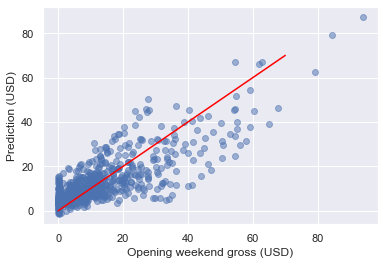

In [964]:
# Reports for model with all features
split_and_validate(X,y)

In [965]:
# # Reports for model with features of movie only
# X, y = get_Xy(c_movie_df)
# split_and_validate(X,y)

In [966]:
def get_score(X_train,X_val,y_train,y_val):
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
        
    
    # Visualization
    fig, ax = plt.subplots(1, 1)
    plt.scatter(y_val, y_pred)

    ax.set_xlabel('Opening weekend gross (USD)')
    ax.set_ylabel('Prediction (USD)')

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

    x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)
    
    y=x
    plt.plot(x,y,color='red')

### Cross-validation

In [916]:
# Will not use X_test, y_test
lr = LinearRegression()

# X, y = get_Xy(c_movie_df)

# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.4952746912735127
[0.54014443 0.44291288 0.52722044 0.5179398  0.44815591]


In [350]:
# result = cross_val_score(lr, X_train, y_train, # estimator, features, target
#                 cv=5, # number of folds 
#                 scoring='r2') # scoring metric

In [351]:
# # mean of val_score
# print("Meam of validation score is:", np.mean(result))
# print(result)

### Find outliers and evaluate the model again

## 2. Basic Feature Engineering

### Split the data set into Train / Validation / Test sets

In [917]:
# Choose df
# X, y = get_Xy(c_movie_df)
X, y = get_Xy(c_movie_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

### * Scaled Features

In [918]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [919]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled,y_train), lr.score(scaler.transform(X_val),y_val)

(0.6091331138581555, 0.6295594416372436)

In [920]:
list(zip((con_feature),lr.coef_))

[('budget', 10.64992127348399),
 ('runtime', -1.473916405937492),
 ('release_year', 0.6997945412836499)]

In [921]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.606888770474088
[0.62482657 0.63405651 0.56755111 0.58579418 0.62221549]


### * Polynomial Fearues
(degree=2): Adding interaction terms and second order feature.

In [922]:
# Only with interaction terms
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = True)

X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

lr.fit(X_train_poly,y_train)
lr.score(X_train_poly,y_train), lr.score(X_val_poly,y_val)

(0.6107771467644758, 0.627595437541874)

In [923]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train_poly, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.6069348681404447
[0.62615559 0.63505917 0.56939587 0.57936717 0.62469654]


In [924]:
# increased train score, but decreased val score.
# overfitting

In [933]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

lr.fit(X_train_poly,y_train)
lr.score(X_train_poly,y_train), lr.score(X_val_poly,y_val)

(0.6112128595641906, 0.6284341911072298)

In [934]:
feature = poly.get_feature_names(con_feature)
list(zip((feature),lr.coef_))

[('1', 0.0),
 ('budget', 10.505691152984603),
 ('runtime', -1.5366390012730557),
 ('release_year', 1.0622914038239524),
 ('budget^2', -0.13179768151732107),
 ('budget runtime', -0.06136324306904866),
 ('budget release_year', 1.0495879741741216),
 ('runtime^2', 0.009880843443800748),
 ('runtime release_year', -0.2342608659263133),
 ('release_year^2', -0.14195821752534)]

In [930]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train_poly, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.6061871572432634
[0.6252968  0.63482906 0.56921639 0.57735525 0.62423829]


In [932]:
# overfitting even more

## 3. Intermediate Feature Engineering: Categorical features
Use `OneHotEncoder` or `pd.get_dummies(df['column'])` to treat categorical variables

### 1. genre

In [935]:
all_df.info(), con_feature

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 4 to 4998
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          3667 non-null   object        
 1   rating               3667 non-null   float64       
 2   vote                 3667 non-null   float64       
 3   MPAA                 3667 non-null   object        
 4   genre                3667 non-null   object        
 5   release_date         3667 non-null   datetime64[ns]
 6   metascore            1461 non-null   float64       
 7   keywords             3667 non-null   object        
 8   budget               3244 non-null   float64       
 9   opening_weekend_usa  3667 non-null   float64       
 10  gross_usa            3667 non-null   float64       
 11  gross_world          3666 non-null   float64       
 12  runtime              3666 non-null   float64       
 13  distributor          3665 non-nul

(None, ['budget', 'runtime', 'release_year'])

In [936]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['genre']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [937]:

# Train set
# Convert genre to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


#Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.fit_transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


#Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]


# # Test set
# # Convert genre to dummies
# X_test_genre = X_test['genre'].str.join(sep='*').str.get_dummies(sep='*')

# # Scaling continuous variables
# X_test_con = X_test[con_feature]
# X_test_con_scaled = scaler.transform(X_test_con)
# X_test_con_scaled_df = pd.DataFrame(X_test_con_scaled, columns=X_test_con.columns, index=X_test_con.index)

# #Combine
# X_test = pd.concat([X_test_genre,X_test_con_scaled_df],axis=1)
# keep2 = list(set(keep).intersection(set(X_test.columns)))
# X_test = X_test[keep2]

In [938]:
X_train.shape, X_val.shape, X_test.shape

((1945, 30), (649, 30), (649, 4))

In [939]:
# X_train


Train R^2 score was: 0.6312620070718025
Validation R^2 score was: 0.6538644349534796
Feature coefficient results: 

budget : 0.67
runtime : -3.01
release_year : -0.28
genre : -0.80


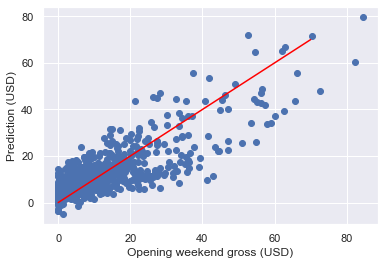

In [940]:
get_score(X_train, X_val, y_train, y_val) # only scaling


Train R^2 score was: 0.6312620070718025
Validation R^2 score was: 0.6538644349534796
Feature coefficient results: 

budget : 0.67
runtime : -3.01
release_year : -0.28
genre : -0.80


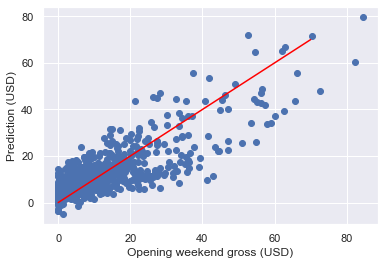

In [941]:
get_score(X_train, X_val, y_train, y_val) # scaling+poly

In [942]:
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.6312620070718025

In [943]:
lr.coef_

array([ 6.65305617e-01, -3.00914452e+00, -2.83727274e-01, -8.04865695e-01,
       -1.78035441e+00, -1.37687155e-01, -1.41571638e-01,  8.64445668e-01,
       -2.11591497e-01,  1.42280587e+00, -3.47197258e+00,  1.37797775e+00,
        9.86192129e+00, -3.91503906e+00,  8.82001396e-01, -7.46526153e-01,
        7.71794943e-02, -2.55238800e+00, -1.50358710e-01,  1.33226763e-15,
       -6.31975801e-02, -5.83987527e-01,  3.81629541e-01,  1.46552342e-01,
        1.92085031e+00,  9.61402631e-01,  1.04336222e+00, -1.52596801e-01,
       -4.80019509e-01, -1.00566169e+00])

In [944]:
# pd.DataFrame(list(zip(X_train.columns,lr.coef_))).sort_values(by=[1],ascending=False)

In [945]:
lr.score(X_val,y_val)

0.6538644349534796

In [946]:
X_train.shape,y_train.shape

((1945, 30), (1945,))

In [947]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.614700479954019
[0.58057984 0.63623856 0.64514635 0.5918577  0.61967995]


### 2. MPAA rating

In [948]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['MPAA']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [949]:
# Train set
# Convert genre to dummies
X_train_genre = X_train['MPAA'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['MPAA'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.fit_transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)


# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.6052464755899105
Validation R^2 score was: 0.6210116489603429
Feature coefficient results: 

budget : -1.55
runtime : 1.01
release_year : -0.61
MPAA : 1.54


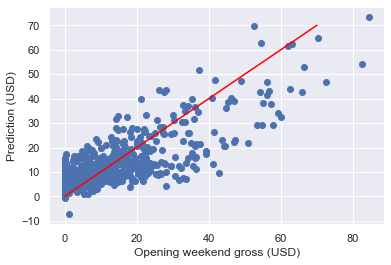

In [950]:
get_score(X_train, X_val, y_train, y_val)

In [951]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.5974870741945415
[0.53767743 0.61513439 0.61443569 0.61012426 0.6100636 ]


In [952]:
# all_df.info()

### 3. language

In [953]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['language']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [954]:
# Train set
# Convert genre to dummies
X_train_genre = X_train['language'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['language'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.fit_transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)


# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.6143766052016362
Validation R^2 score was: 0.6027190358779049
Feature coefficient results: 

budget : -0.80
runtime : 3.93
release_year : -5.20
language : -3.50


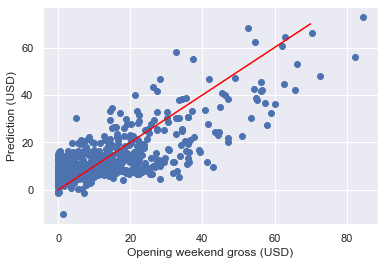

In [955]:
get_score(X_train, X_val, y_train, y_val)

In [956]:
# X_train.info()

In [957]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: -1.177780418051331e+22
[-7.73897109e+21 -2.20467838e+15  6.11823947e-01 -5.11500476e+22
 -8.90459676e+07]


### 4. country

In [958]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['country']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [959]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.fit_transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]

In [866]:
pd.DataFrame(X_train_genre.sum()).sort_values(by=[0],ascending=False)

,0
USA,2071
UK,384
Canada,188
Germany,154
France,145
...,...
NorthKorea,1
Panama,1
Slovenia,1
Singapore,1



Train R^2 score was: 0.5234214751163859
Validation R^2 score was: 0.4830423833481903
Feature coefficient results: 

budget : 3.64
runtime : -3.11
release_year : 0.07
country : -0.75


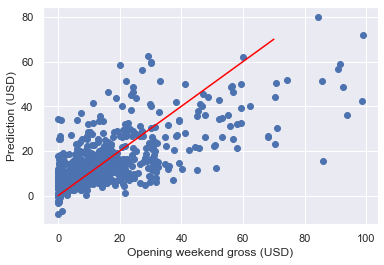

In [855]:
get_score(X_train, X_val, y_train, y_val)

In [856]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.4952746912735127
[0.54014443 0.44291288 0.52722044 0.5179398  0.44815591]


### 5. distributor

In [382]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['distributor']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [383]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['distributor'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['distributor'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.fit_transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.47946516536238315
Validation R^2 score was: 0.48286620606740405
Feature coefficient results: 

budget : 0.42
runtime : 0.16
release_year : -0.69
distributor : 0.49


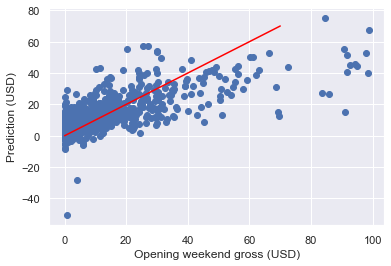

In [384]:
get_score(X_train, X_val, y_train, y_val)

In [386]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: -2.5078038437472117e+19
[ 4.47836294e-01 -1.25390192e+20  4.07681873e-01  1.57570409e-01
  4.79229774e-01]


### 7. actor

In [967]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['star']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [968]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.fit_transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]

In [969]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['star']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [970]:
#
## scaling + poly

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


#Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.fit_transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


#Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [971]:
# X_train_genre


Train R^2 score was: 0.6629678841738382
Validation R^2 score was: 0.6070203961378139
Feature coefficient results: 

budget : -2.29
runtime : -0.87
release_year : -1.30
star : 3.44


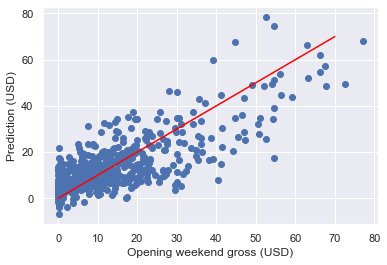

In [972]:
get_score(X_train, X_val, y_train, y_val)

In [973]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.604101070517906
[0.59353453 0.64136877 0.60426265 0.59872306 0.58261634]


### 6. all categorical variables

#### * all categorical variables + scaling

In [979]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [980]:

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)
            
            
# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [981]:
X_train.shape, X_val.shape

((1945, 323), (649, 323))


Train R^2 score was: 0.7179542337245232
Validation R^2 score was: -8.89743074602731e+24
Feature coefficient results: 

budget : -2.33
runtime : -2.80
release_year : -3.02
genre : -2.78
MPAA : 7.17
language : 2.10
country : -0.09
distributor : -6.64
star : 1.59


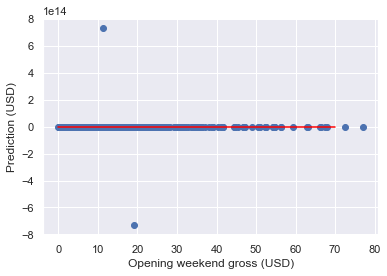

In [982]:
get_score(X_train, X_val, y_train, y_val)

In [984]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: -2.1543444759595957e+24
[-3.13860357e+21 -1.05552160e+25 -5.78754177e+22 -1.43123561e+23
 -1.23688312e+22]


#### * All categorical variables + scaling + polynomial features

In [985]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [986]:

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


# Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.fit_transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


# Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [987]:
X_train.shape, X_val.shape

((1945, 109), (649, 109))

In [988]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.6629678841738382

In [989]:
list(zip(poly.get_feature_names(X_val_con.columns), lr.coef_))

[('1', -2.2932571508140427),
 ('budget', -0.870053497791391),
 ('runtime', -1.3047244233234263),
 ('release_year', 3.444411202909062),
 ('budget^2', 1.1079023725568686),
 ('budget runtime', -2.7175887694219174),
 ('budget release_year', -3.145365731443444),
 ('runtime^2', 0.318859563264275),
 ('runtime release_year', -1.1399952530622077),
 ('release_year^2', -5.589054384387402)]


Train R^2 score was: 0.6629678841738382
Validation R^2 score was: 0.6070203961378139
Feature coefficient results: 

budget : -2.29
runtime : -0.87
release_year : -1.30
genre : 3.44
MPAA : 1.11
language : -2.72
country : -3.15
distributor : 0.32
star : -1.14


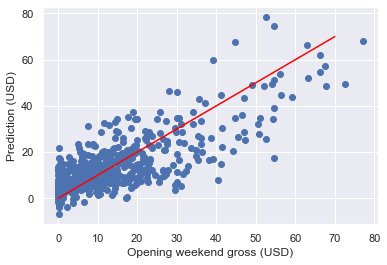

In [990]:
get_score(X_train, X_val, y_train, y_val)

In [992]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.604101070517906
[0.59353453 0.64136877 0.60426265 0.59872306 0.58261634]


In [320]:
# all_variable_score('movie only')

In [321]:
# all_variable_score('movie+book')

## 4. Incorporate Polynomial Features

In [999]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only = True)


# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = poly.fit_transform(scaler.fit_transform(X_train_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns = poly_column,\
                                     index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = poly.transform(scaler.fit_transform(X_val_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns = poly_column,\
                                   index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]


Train R^2 score was: 0.7217599911011177
Validation R^2 score was: 0.552856287760285
Feature coefficient results: 

budget : -1.48
runtime : -3.21
release_year : -1.42
genre : -3.16
MPAA : 7.34
language : 2.09
country : -0.15
distributor : -6.79
star : 2.29


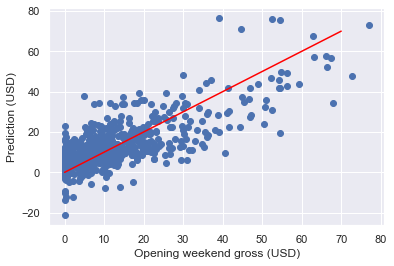

In [1000]:
get_score(X_train, X_val, y_train, y_val)

In [1001]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: -1.6137588493625806e+24
[-3.07617397e+22 -2.07961583e+24 -3.14980693e+22 -5.90763403e+24
 -1.92845760e+22]



Train R^2 score was: 0.7058985260546331
Validation R^2 score was: -8.942910051390256e+19
Feature coefficient results: 

budget : -3.08
runtime : -2.79
release_year : 4.76
genre : 1.14
MPAA : -1.07
language : -20.64
country : -4.37
distributor : -2.73


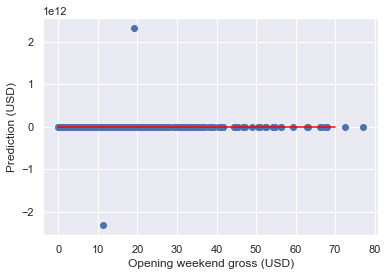

In [995]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only = False)


# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = poly.fit_transform(scaler.fit_transform(X_train_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns = poly_column,\
                                     index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = poly.transform(scaler.fit_transform(X_val_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns = poly_column,\
                                   index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

get_score(X_train, X_val, y_train, y_val)

### Find outliers and evaluate the model again

In [820]:
lc_df = all_df[['movie_title'] + ['opening_weekend_usa'] + con_feature + 
               ['genre','release_year','rating']].copy().dropna()

In [823]:
X = lc_df[con_feature + ['rating']]
y = lc_df['opening_weekend_usa']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=58)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)
lc_df['res'] = lr.predict(lc_df[con_feature + ['rating']])-lc_df['opening_weekend_usa']

In [878]:
res1 = lc_df[['movie_title','release_year','genre','res']].sort_values(['res']).head(100)
res1

,movie_title,release_year,release_year,genre,res
46,Joker,2019,2019,"[Crime, Drama, Thriller]",-76.857885
234,Fifty Shades of Grey,2015,2015,"[Drama, Romance, Thriller]",-71.294337
457,It Chapter Two,2019,2019,"[Drama, Fantasy, Horror]",-68.088223
1600,Halloween,2018,2018,"[Crime, Horror, Thriller]",-67.851580
325,Harry Potter and the Chamber of Secrets,2002,2002,"[Adventure, Family, Fantasy]",-62.206409
...,...,...,...,...,...
338,The Hangover,2009,2009,[Comedy],-31.348815
1735,Friday the 13th,2009,2009,"[Horror, Mystery, Thriller]",-31.308174
450,Sonic the Hedgehog,2020,2020,"[Action, Adventure, Comedy]",-30.938759
644,Ant-Man and the Wasp,2018,2018,"[Action, Adventure, Comedy]",-30.790388


In [882]:
res2 = lc_df[['movie_title','release_year','genre','res']].sort_values(['res']).tail(100)
res2

,movie_title,release_year,release_year,genre,res
141,The Greatest Showman,2017,2017,"[Biography, Drama, Musical]",17.742290
1372,Tomorrowland,2015,2015,"[Action, Adventure, Family]",17.839777
1733,Perfume: The Story of a Murderer,2007,2007,"[Crime, Drama, Fantasy]",17.975599
3041,Rumor Has It...,2005,2005,"[Comedy, Drama, Romance]",18.043484
2970,Ben-Hur,2016,2016,"[Action, Adventure, Drama]",18.313404
...,...,...,...,...,...
2963,Brother Bear,2003,2003,"[Animation, Adventure, Comedy]",35.847114
280,The Revenant,2016,2016,"[Action, Adventure, Drama]",36.606271
2390,47 Ronin,2013,2013,"[Action, Drama, Fantasy]",37.128046
409,Frozen,2013,2013,"[Animation, Adventure, Comedy]",41.936848


In [886]:
res_df = pd.concat([res1,res2],axis=0)
res_movie = res.movie_title.tolist()

In [827]:
all_df[all_df.movie_title == "Kiki's Delivery Service"]

,movie_title,rating,vote,MPAA,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,distributor,language,country,director,writer,star,link_d,link_w,link_s,release_year
2063,Kiki's Delivery Service,7.8,123657.0,G,"[Animation, Adventure, Drama]",1990-12-20,83.0,"[witch, cat, studio ghibli, goodwill, magic]",800000000.0,0.352556,...,Kiki'sDeliveryServiceProductionCommittee,"[Japanese, English]","[Japan, USA]",Hayao Miyazaki,"[Eiko Kadono, Hayao Miyazaki]","[Kirsten Dunst, Minami Takayama, Rei Sakuma]",/name/nm0594503/,"[/name/nm0434395/, /name/nm0594503/]","[/name/nm0000379/, /name/nm0847439/, /name/nm0...",1990


## 4. Regularization

In [1002]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

### * Ridge

In [95]:
## Fit a Ridge model on the standardized data

# ridge_model = Ridge(alpha = 0.001)
# ridge_model.fit(X_train,y_train)
# list(zip(X_train.columns, ridge_model.coef_))

In [1011]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)
print('The best value of alpha is:', ridge_model.alpha_)

The best value of alpha is: 14.694918006248173


In [1003]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 9)
ridge_model.fit(X_train,y_train)
list(zip(X_train.columns, ridge_model.coef_))

[('Jack Nicholson', -0.626484461243909),
 ('FoxSearchlightPictures', -2.400308877331024),
 ('G', 0.7220833811875199),
 ('NewZealand', -1.2008162667949525),
 ('Czech', 1.6136445284733223),
 ('UnitedArtists', 1.1927543846651878),
 ('STXFilms', -0.1184779480530019),
 ('Russell Crowe', -3.7964302145892677),
 ('George Clooney', 0.9002704413734319),
 ('Greek', 2.9724801169592534),
 ('AmericanSignLanguage', -0.1597937972117652),
 ('DimensionFilms', 4.827456153479279),
 ('RevolutionStudios', 1.7384799529939141),
 ('ConstellationEntertainment', -0.36257178075457624),
 ('PG-13', 0.9372032354201226),
 ('BadRobot', -0.9126506754874433),
 ('WaltDisneyAnimationStudios', -2.267288938960053),
 ('Shia LaBeouf', 1.2217035651042012),
 ('Yiddish', 1.770155909965857),
 ('Susan Sarandon', 0.7315849680638866),
 ('Michelle Pfeiffer', -0.16971590472353668),
 ('Jude Law', -1.4902917034793672),
 ('SidneyKimmelEntertainment', -0.20993356529569365),
 ('MandalayEntertainment', 0.9096118297595445),
 ('Keira Knightle

In [491]:
top_key = pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_)),columns=['key','coef'])
top_key.sort_values(by='coef',ascending=False).head(20)

,key,coef
227,budget,10.935559
56,Lucasfilm,6.946843
63,MarvelStudios,6.180770
199,NewLineCinema,5.470673
58,SouthKorea,5.176082
169,Animation,4.677467
101,DreamWorksAnimation,4.480670
213,ScreenGems,4.428600
2,TwistedPictures,4.286668
34,TwentiethCenturyFoxAnimation,4.218576


In [497]:
top_key[top_key.key.isin(actor_list)]

,key,coef


In [498]:
len(top_key.key)

268

In [1005]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 9)
ridge_model.fit(X_train_con_scaled_df,y_train)
list(zip(X_train_con_scaled_df.columns, ridge_model.coef_))

[('1', 0.0),
 ('budget', 10.790618270578577),
 ('runtime', -1.5901919249599614),
 ('release_year', 1.0475192630001275),
 ('budget runtime', 0.41360357112924545),
 ('budget release_year', 0.8134108466760998),
 ('runtime release_year', -0.40008266845410717)]

In [1006]:
val_pred = ridge_model.predict(X_val_con_scaled_df)
r2_score(y_val, val_pred)

0.6280066942795596


Train R^2 score was: 0.7217599911011177
Validation R^2 score was: 0.552856287760285
Feature coefficient results: 

budget : -1.48
runtime : -3.21
release_year : -1.42
genre : -3.16
MPAA : 7.34
language : 2.09
country : -0.15
distributor : -6.79
star : 2.29


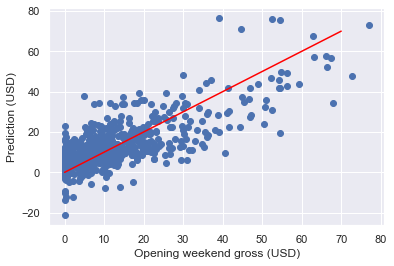

In [1007]:
get_score(X_train, X_val, y_train, y_val)

### * LASSO

In [1008]:
lasso_model = Lasso(alpha = 0.001)
lasso_model.fit(X_train_con_scaled_df,y_train)
list(zip(X_train_con_scaled_df.columns, lasso_model.coef_))

[('1', 0.0),
 ('budget', 10.869471240606385),
 ('runtime', -1.611672469933273),
 ('release_year', 1.0161579684797188),
 ('budget runtime', 0.4049149340124763),
 ('budget release_year', 0.7715600057139052),
 ('runtime release_year', -0.40032965382437763)]

In [415]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha


alphavec = 10**np.linspace(-5,5,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_con_scaled_df, y_train)
print('The best value of alpha is:', lasso_model.alpha_)

The best value of alpha is: 0.03660695147596903


In [1009]:
lasso_model = Lasso(alpha = 0.036)
lasso_model.fit(X_train_con_scaled_df,y_train)
list(zip(X_train_con_scaled_df.columns, lasso_model.coef_))

[('1', 0.0),
 ('budget', 10.877745596221406),
 ('runtime', -1.5474948072327137),
 ('release_year', 0.9493614150583384),
 ('budget runtime', 0.36337683954390504),
 ('budget release_year', 0.6831753238740066),
 ('runtime release_year', -0.3289324434094806)]

In [1010]:
val_pred = lasso_model.predict(X_val_con_scaled_df)
r2_score(y_val, val_pred)

0.6284271657771358